### Labrador Embeddings

In [1]:
import pandas as pd
import torch
import numpy as np
import torch.nn as nn

from src.preprocessing import preprocess_df, TextEncoder, set_labels_features
from sklearn.model_selection import train_test_split

from src.labrador import Labrador
from src.tokenizers import LabradorTokenizer
from src.dataset import LabradorDataset

from src.train import train_labrador
from src.test import test_model

### Constants

In [2]:
# Dataset:
FILE = 'data/morning_lab_values.csv'
COLUMNS = ['Bic', 'Crt', 'Pot', 'Sod', 'Ure', 'Hgb', 'Plt', 'Wbc']

# Device:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('mps') if torch.cuda.is_available() else torch.device('cpu') # Apple Silicon

# Data loader: 
test_size = 0.2
batch_size = 512
num_workers = 4
max_len = 8
MASKING = 0.40

# Model:
embedding_dim = 756
hidden_dim = 756
transformer_heads = 4 #12
num_blocks = 10 #12
transformer_feedforward_dim = 1024 #3072
dropout_rate = 0.3
continuous_head_activation = 'relu'

# Training:
optimizer = 'Adam'
num_epochs = 12
save_model = True
model_path = 'labrador_model.pth'
categorical_loss_weight = 1.0
continuous_loss_weight = 1.0
lr = 8e-6


### Read dataset

In [3]:
df = pd.read_csv(FILE)
df.head()

,hadm_id,subject_id,itemid,charttime,charthour,storetime,storehour,chartday,valuenum,cnt
0,NaN,10312413,51222,2173-06-05 08:20:00,8,2173-06-05 08:47:00,8,2173-06-05,12.8,8
1,25669789.0,10390828,51222,2181-10-26 07:55:00,7,2181-10-26 08:46:00,8,2181-10-26,9.4,8
2,26646522.0,10447634,51222,2165-03-07 06:55:00,6,2165-03-07 07:23:00,7,2165-03-07,11.1,8
3,27308928.0,10784877,51222,2170-05-11 06:00:00,6,2170-05-11 06:43:00,6,2170-05-11,10.3,8
4,28740988.0,11298819,51222,2142-09-13 07:15:00,7,2142-09-13 09:23:00,9,2142-09-13,10.2,8


### Preprocessing

In [4]:
# MinMaxScaler by default
mrl = preprocess_df(df, columns_to_scale=COLUMNS)

### Generate Sequences

In [5]:
# Generate the sequences:
text_encoder = TextEncoder(Repetition_id=True, labs_as_num=True, return_lists=True)
mrl, grouped_mrl = text_encoder.encode_text(mrl)

In [6]:
mrl.head(3)

itemid,subject_id,hadm_id,chartday,Bic,Crt,Pot,Sod,Ure,Hgb,Plt,Wbc,nstr,lab_ids,lab_values
0,10000032,22595853.0,2180-05-07,0.530612,0.007895,0.258621,0.609524,0.088028,0.585253,0.027731,0.004782,Bic 0.5306122448979591 Crt 0.00789473684210526...,"[Bic, Crt, Pot, Sod, Ure, Hgb, Plt, Wbc]","[0.5306122448979591, 0.007894736842105262, 0.2..."
1,10000032,22841357.0,2180-06-27,0.469388,0.007895,0.318966,0.504762,0.102113,0.571429,0.055462,0.007515,Bic 0.46938775510204084 Crt 0.0078947368421052...,"[Bic, Crt, Pot, Sod, Ure, Hgb, Plt, Wbc]","[0.46938775510204084, 0.007894736842105262, 0...."
2,10000032,25742920.0,2180-08-06,0.489796,0.015789,0.413793,0.504762,0.130282,0.557604,0.053782,0.008539,Bic 0.48979591836734687 Crt 0.0157894736842105...,"[Bic, Crt, Pot, Sod, Ure, Hgb, Plt, Wbc]","[0.48979591836734687, 0.015789473684210523, 0...."


In [7]:
# See the largest element in: 
grouped_mrl.head(3)

,hadm_id,nstr,lab_ids,lab_values
0,20000019.0,[Bic 0.4489795918367347 Crt 0.0289473684210526...,"[Bic, Crt, Pot, Sod, Ure, Hgb, Plt, Wbc]","[0.4489795918367347, 0.02894736842105263, 0.17..."
1,20000024.0,[Bic 0.46938775510204084 Crt 0.028947368421052...,"[Bic, Crt, Pot, Sod, Ure, Hgb, Plt, Wbc]","[0.46938775510204084, 0.02894736842105263, 0.3..."
2,20000034.0,[Bic 0.4489795918367347 Crt 0.0605263157894736...,"[Bic, Crt, Pot, Sod, Ure, Hgb, Plt, Wbc]","[0.4489795918367347, 0.06052631578947368, 0.28..."


#### Train and Test Split

In [8]:
lab_ids = grouped_mrl.lab_ids.values
lab_values = grouped_mrl.lab_values.values

lab_ids_train, lab_ids_test, lab_values_train, lab_values_test = train_test_split(lab_ids, lab_values, test_size=test_size, random_state=42)

#### Tokenize

In [9]:
tokenizer = LabradorTokenizer()
# Get unique lab ids:
unique_ids = set(np.concatenate(lab_ids_train))
# train the tokenizer:
tokenizer.train(unique_ids)

In [10]:
# Example of how to use the tokenizer:
tokenizer.tokenize_batch(lab_ids_train[:5], lab_values_train[:5], max_length=10)

{'input_ids': array([[ 7,  3,  4,  5,  2,  0,  6,  1, 10, 10],
        [ 7,  3,  4,  5,  2,  0,  6,  1, 10, 10],
        [ 7,  3,  4,  5,  2,  0,  6,  1, 10, 10],
        [ 7,  3,  4,  5,  2,  0,  6,  1, 10, 10],
        [ 7,  3,  4,  5,  2,  0,  6,  1, 10, 10]]),
 'continuous': array([[6.73469388e-01, 7.89473684e-02, 1.46551724e-01, 6.09523810e-01,
         3.80281690e-01, 6.31336406e-01, 4.15966387e-02, 6.94523511e-03,
         1.00000000e+01, 1.00000000e+01],
        [6.12244898e-01, 2.89473684e-02, 1.37931034e-01, 7.04761905e-01,
         9.85915493e-02, 3.50230415e-01, 7.85714286e-02, 1.04747808e-02,
         1.00000000e+01, 1.00000000e+01],
        [5.30612245e-01, 2.10526316e-02, 2.06896552e-01, 6.28571429e-01,
         5.63380282e-02, 4.42396313e-01, 1.18067227e-01, 1.04747808e-02,
         1.00000000e+01, 1.00000000e+01],
        [4.48979592e-01, 1.84210526e-02, 2.32758621e-01, 6.28571429e-01,
         3.16901408e-02, 6.77419355e-01, 1.07983193e-01, 1.04747808e-02,
         1.

### Dataloader

In [11]:
dataset_train = LabradorDataset(continuous=lab_values_train, categorical=lab_ids_train, tokenizer=tokenizer, max_len=max_len, masking_prob=MASKING)
dataset_test = LabradorDataset(continuous=lab_values_test, categorical=lab_ids_test, tokenizer=tokenizer, max_len=max_len, masking_prob=MASKING)

# Dataloader:
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=True, num_workers=num_workers)

{'[MASK]': 8, '[NULL]': 9, '[PAD]': 10, 'Hgb': 0, 'Wbc': 1, 'Ure': 2, 'Crt': 3, 'Pot': 4, 'Sod': 5, 'Plt': 6, 'Bic': 7}
{'[MASK]': 8, '[NULL]': 9, '[PAD]': 10, 'Hgb': 0, 'Wbc': 1, 'Ure': 2, 'Crt': 3, 'Pot': 4, 'Sod': 5, 'Plt': 6, 'Bic': 7}


### Model

In [12]:
mask_token = tokenizer.mask_token #-1
null_token = tokenizer.null_token #-2
pad_token = tokenizer.pad_token #-3
vocab_size = tokenizer.vocab_size()

In [13]:
model = Labrador(mask_token=mask_token, pad_token=pad_token, null_token=null_token, vocab_size=vocab_size, embedding_dim=embedding_dim, transformer_heads=transformer_heads, num_blocks=num_blocks, transformer_feedforward_dim=transformer_feedforward_dim, include_head=True, continuous_head_activation=continuous_head_activation, dropout_rate=dropout_rate)
model

Labrador(
  (categorical_embedding_layer): Embedding(14, 756)
  (continuous_embedding_layer): ContinuousEmbedding(
    (special_token_embeddings): Embedding(3, 756)
    (dense1): Linear(in_features=1, out_features=756, bias=True)
    (dense2): Linear(in_features=756, out_features=756, bias=True)
    (layernorm): LayerNorm((756,), eps=1e-05, elementwise_affine=True)
  )
  (projection_layer): Linear(in_features=1512, out_features=756, bias=True)
  (blocks): ModuleList(
    (0-9): 10 x TransformerBlock(
      (att): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=756, out_features=756, bias=True)
      )
      (ffn): Sequential(
        (0): Linear(in_features=756, out_features=1024, bias=True)
        (1): ReLU()
        (2): Linear(in_features=1024, out_features=756, bias=True)
      )
      (layernorm1): LayerNorm((756,), eps=1e-05, elementwise_affine=True)
      (layernorm2): LayerNorm((756,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dr

### Train the model

In [14]:
# Loss functions
categorical_loss_fn = nn.CrossEntropyLoss()
continuous_loss_fn = nn.MSELoss()

100%|██████████| 104/104 [00:06<00:00, 16.97it/s]


Epoch 1/2, Training Loss: 2.2173422845665383, Validation Loss: 1.9140052497386932


100%|██████████| 104/104 [00:06<00:00, 17.00it/s]


Epoch 2/2, Training Loss: 1.869588714002987, Validation Loss: 1.8220085077560866


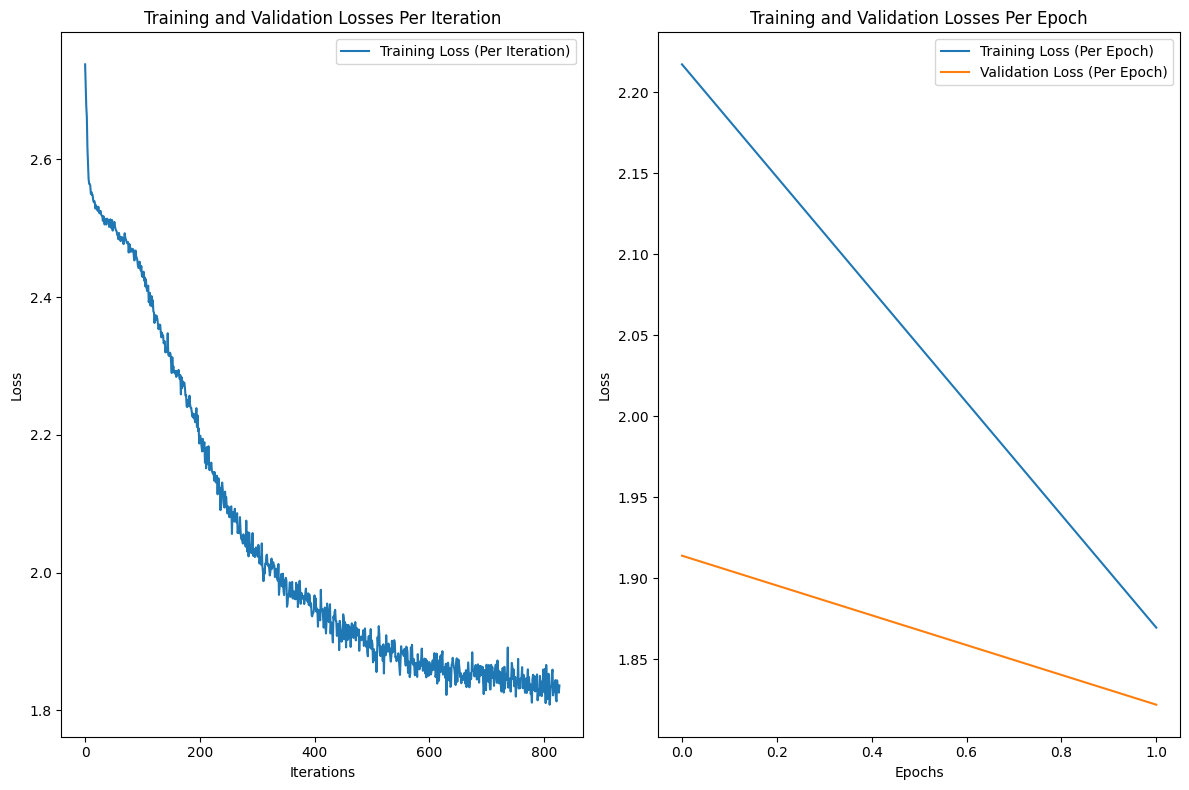

In [15]:
# Train and validate the model
trained_model = train_labrador(model, train_loader, test_loader, categorical_loss_fn, continuous_loss_fn, optimizer=optimizer, num_epochs=num_epochs, device=device, save_model=save_model, model_path=model_path, categorical_loss_weight=categorical_loss_weight, continuous_loss_weight=continuous_loss_weight, lr=lr)

### Test the model

In [16]:
dataset_test = LabradorDataset(continuous=lab_values_test, categorical=lab_ids_test, tokenizer=tokenizer, max_len=max_len, masking_prob=0)
# Dataloader:
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

{'[MASK]': 8, '[NULL]': 9, '[PAD]': 10, 'Hgb': 0, 'Wbc': 1, 'Ure': 2, 'Crt': 3, 'Pot': 4, 'Sod': 5, 'Plt': 6, 'Bic': 7}


In [17]:
test_model(model, test_loader, device, COLUMNS)

Evaluating Bic: 


  3%|▎         | 3/104 [00:00<00:13,  7.41it/s]

Preds: [0.4824146032333374, 0.48416709899902344, 0.4856193959712982, 0.4831598103046417, 0.4819473624229431, 0.4820976257324219, 0.48452267050743103, 0.4795958697795868, 0.47499120235443115, 0.4848729968070984, 0.48251521587371826, 0.48065808415412903, 0.4832153618335724, 0.482725590467453, 0.47790926694869995, 0.4823189973831177, 0.4853014647960663, 0.483969509601593, 0.48349905014038086, 0.47927290201187134, 0.483122318983078, 0.4714905619621277, 0.4833718240261078, 0.48368293046951294, 0.48412781953811646, 0.4827386438846588, 0.48446840047836304, 0.4831864535808563, 0.48067960143089294, 0.48283815383911133, 0.48250722885131836, 0.4821122884750366, 0.48408305644989014, 0.4836609363555908, 0.4825425446033478, 0.4842022657394409, 0.4868430197238922, 0.48434898257255554, 0.48318547010421753, 0.48331859707832336, 0.4827893376350403, 0.48116883635520935, 0.4853169023990631, 0.4835496246814728, 0.48081135749816895, 0.4826410412788391, 0.48402369022369385, 0.4809868633747101, 0.483785629272

100%|██████████| 104/104 [00:06<00:00, 17.29it/s]


RMSE: 0.078
MAE: 0.059
R2: 0.008
-------------------
Evaluating Crt: 


  3%|▎         | 3/104 [00:00<00:13,  7.37it/s]

Preds: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

100%|██████████| 104/104 [00:06<00:00, 17.30it/s]


RMSE: 0.053
MAE: 0.035
R2: -0.733
-------------------
Evaluating Pot: 


  3%|▎         | 3/104 [00:00<00:14,  7.14it/s]

Preds: [0.20727801322937012, 0.20674137771129608, 0.20649871230125427, 0.2068297117948532, 0.2072698324918747, 0.20826534926891327, 0.20721645653247833, 0.20875237882137299, 0.2084251493215561, 0.20677506923675537, 0.20654329657554626, 0.20780086517333984, 0.20621921122074127, 0.20709358155727386, 0.2071160227060318, 0.20784808695316315, 0.20654572546482086, 0.2074495553970337, 0.2055780589580536, 0.20796318352222443, 0.2070809155702591, 0.21281765401363373, 0.20621474087238312, 0.20755617320537567, 0.20702379941940308, 0.2067289501428604, 0.2065972238779068, 0.20559024810791016, 0.20850320160388947, 0.2070007622241974, 0.20689216256141663, 0.20800374448299408, 0.2063245326280594, 0.20674778521060944, 0.2066689282655716, 0.20692087709903717, 0.20618903636932373, 0.20632781088352203, 0.20680665969848633, 0.2068670392036438, 0.20708726346492767, 0.20671716332435608, 0.2061738818883896, 0.20856468379497528, 0.20745618641376495, 0.20846296846866608, 0.20694926381111145, 0.2076094150543213,

100%|██████████| 104/104 [00:06<00:00, 17.14it/s]


RMSE: 0.049
MAE: 0.037
R2: -0.133
-------------------
Evaluating Sod: 


  3%|▎         | 3/104 [00:00<00:13,  7.24it/s]

Preds: [0.6579123139381409, 0.656204104423523, 0.6598479151725769, 0.6550115942955017, 0.6549716591835022, 0.6524355411529541, 0.6584692597389221, 0.6535999178886414, 0.6532605290412903, 0.6602403521537781, 0.6555525660514832, 0.6543349027633667, 0.655648410320282, 0.6587072014808655, 0.6528449654579163, 0.6572394371032715, 0.6580528020858765, 0.6554436683654785, 0.6589856743812561, 0.6534438133239746, 0.655574381351471, 0.6531946659088135, 0.657982587814331, 0.6544691920280457, 0.6550882458686829, 0.6563253402709961, 0.6547605991363525, 0.6579877734184265, 0.6534261703491211, 0.6533739566802979, 0.6559193134307861, 0.6544959545135498, 0.6574013829231262, 0.6562626957893372, 0.6550946831703186, 0.6568591594696045, 0.6620817184448242, 0.6599004864692688, 0.6556562781333923, 0.6573241949081421, 0.657085120677948, 0.6558427810668945, 0.6575202345848083, 0.6536951661109924, 0.6539508104324341, 0.6541928648948669, 0.6576083898544312, 0.6543612480163574, 0.6598260998725891, 0.65742027759552,

100%|██████████| 104/104 [00:06<00:00, 17.22it/s]


RMSE: 0.048
MAE: 0.037
R2: -0.620
-------------------
Evaluating Ure: 


  3%|▎         | 3/104 [00:00<00:13,  7.31it/s]

Preds: [0.06836220622062683, 0.062162432819604874, 0.06702287495136261, 0.06004488840699196, 0.058766935020685196, 0.05836261436343193, 0.06738299131393433, 0.06994181871414185, 0.06829169392585754, 0.068052276968956, 0.06172307953238487, 0.06280255317687988, 0.06129270792007446, 0.06910397112369537, 0.061654362827539444, 0.06964477896690369, 0.06547294557094574, 0.06369933485984802, 0.06620775908231735, 0.0614115409553051, 0.062352605164051056, 0.06770175695419312, 0.06414254009723663, 0.06086794659495354, 0.05847405269742012, 0.06410646438598633, 0.05981408432126045, 0.0656551718711853, 0.0596938319504261, 0.056255731731653214, 0.06167663261294365, 0.06057906895875931, 0.06514376401901245, 0.06201640143990517, 0.05961054190993309, 0.06356669962406158, 0.06972792744636536, 0.06777754426002502, 0.05959237739443779, 0.06500086188316345, 0.06749238073825836, 0.06464189291000366, 0.06330134719610214, 0.06187799945473671, 0.06220905855298042, 0.06110292300581932, 0.06714703142642975, 0.065

100%|██████████| 104/104 [00:06<00:00, 17.20it/s]


RMSE: 0.062
MAE: 0.037
R2: -0.003
-------------------
Evaluating Hgb: 


  3%|▎         | 3/104 [00:00<00:13,  7.55it/s]

Preds: [0.5054360032081604, 0.5033411979675293, 0.5043058395385742, 0.504310131072998, 0.5053310990333557, 0.5036417245864868, 0.5055652260780334, 0.502323567867279, 0.5034074187278748, 0.5040427446365356, 0.5022314786911011, 0.5037474036216736, 0.5042654275894165, 0.5045163035392761, 0.5030636191368103, 0.5048495531082153, 0.5052778124809265, 0.504789412021637, 0.5039777159690857, 0.501789927482605, 0.5046491622924805, 0.5091772675514221, 0.5046729445457458, 0.5047624707221985, 0.5045992732048035, 0.5048155784606934, 0.5043628811836243, 0.5049821138381958, 0.5051538944244385, 0.503565788269043, 0.5033054351806641, 0.5043057799339294, 0.5053632259368896, 0.503910481929779, 0.5041376352310181, 0.5045551061630249, 0.5051220655441284, 0.5044242143630981, 0.5036420226097107, 0.5063127875328064, 0.5048888921737671, 0.5027530789375305, 0.5049001574516296, 0.5040112137794495, 0.5031855702400208, 0.5058507323265076, 0.5055004954338074, 0.5037631988525391, 0.5051257014274597, 0.5042357444763184

100%|██████████| 104/104 [00:06<00:00, 17.22it/s]


RMSE: 0.095
MAE: 0.077
R2: -0.000
-------------------
Evaluating Plt: 


  3%|▎         | 3/104 [00:00<00:13,  7.44it/s]

Preds: [0.0916278213262558, 0.09259448945522308, 0.09116245806217194, 0.0927230566740036, 0.09177565574645996, 0.09291332960128784, 0.09164802730083466, 0.09315310418605804, 0.09083303809165955, 0.09135441482067108, 0.09196352958679199, 0.0920599102973938, 0.09225372970104218, 0.09127688407897949, 0.09001126885414124, 0.09200724959373474, 0.09149745106697083, 0.09308429062366486, 0.09057171642780304, 0.09157972037792206, 0.0921516865491867, 0.09065176546573639, 0.0908990353345871, 0.09293562173843384, 0.09268201887607574, 0.09179456532001495, 0.09267759323120117, 0.09090720117092133, 0.0914541631937027, 0.09270787239074707, 0.09199504554271698, 0.09274253249168396, 0.09185826778411865, 0.09234385192394257, 0.09192942082881927, 0.09249462187290192, 0.09213638305664062, 0.09105399250984192, 0.09183579683303833, 0.09163257479667664, 0.09223681688308716, 0.0912027508020401, 0.09149129688739777, 0.09344758093357086, 0.09249165654182434, 0.09202279150485992, 0.09235119819641113, 0.0923176109

100%|██████████| 104/104 [00:06<00:00, 17.14it/s]


RMSE: 0.047
MAE: 0.033
R2: -0.003
-------------------
Evaluating Wbc: 


  3%|▎         | 3/104 [00:00<00:13,  7.62it/s]

Preds: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

100%|██████████| 104/104 [00:06<00:00, 17.22it/s]

RMSE: 0.012
MAE: 0.010
R2: -1.680
-------------------


{'Bic': {'rmse': [0.078162632116498],
  'mae': [0.05923859777889312],
  'r2': [0.008053203904974549]},
 'Crt': {'rmse': [0.05315096578868614],
  'mae': [0.03456101898744428],
  'r2': [-0.7325478394361615]},
 'Pot': {'rmse': [0.04909565570037823],
  'mae': [0.036549425682050087],
  'r2': [-0.13269461976380037]},
 'Sod': {'rmse': [0.04797789489503515],
  'mae': [0.03684335830895091],
  'r2': [-0.6197901254015588]},
 'Ure': {'rmse': [0.061874789110533394],
  'mae': [0.037281279955768194],
  'r2': [-0.0034879657031283706]},
 'Hgb': {'rmse': [0.0945558804128718],
  'mae': [0.07714351600024691],
  'r2': [-6.482866552026678e-05]},
 'Plt': {'rmse': [0.04673176375364399],
  'mae': [0.03306032386263298],
  'r2': [-0.00333465641118047]},
 'Wbc': {'rmse': [0.012445089987730659],
  'mae': [0.00985360168744061],
  'r2': [-1.6802015094659697]}}